In [1]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings
warnings.filterwarnings("ignore")


In [2]:
day_data = pd.read_csv('/Users/home/Github/ADS-506-Final-Team-Project/day.csv')

In [3]:
# Convert 'dteday' to datetime and set as index
day_data['dteday'] = pd.to_datetime(day_data['dteday'])
day_data.set_index('dteday', inplace=True)

# Add new feature: Day of the year
day_data['day_of_year'] = day_data.index.dayofyear

# Add lag features
for lag in range(1, 4):  # Add lag features for 1, 2, and 3 days
    day_data[f'lag_{lag}'] = day_data['cnt'].shift(lag)

# Drop rows with NaN values after creating lag features
day_data = day_data.dropna()


In [4]:
# Select the target variable and relevant features
target = 'cnt'
features = ['temp', 'atemp', 'hum', 'windspeed', 'holiday', 'weekday', 'workingday', 'weathersit']

# Normalize features and target
scaler_features = MinMaxScaler()
day_data[features] = scaler_features.fit_transform(day_data[features])

scaler_target = MinMaxScaler()
day_data[[target]] = scaler_target.fit_transform(day_data[[target]])


In [5]:
# Create sequences
def create_sequences(data, target_col, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data.iloc[i:i+seq_length][features].values)
        y.append(data.iloc[i+seq_length][target_col])
    return np.array(X), np.array(y)

seq_length_values = [120]  # Use past 60 days for prediction
for seq_length in seq_length_values:
    print(f"Experimenting with seq_length = {seq_length}")

    # Create sequences
    X, y = create_sequences(day_data, target, seq_length)


Experimenting with seq_length = 120


In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
import pandas as pd

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# Hyperparameter tuning
learning_rates = [0.001]
batch_sizes = [32]
epochs_list = [50]

# Store results for comparison
results = []

for lr in learning_rates:
    for batch_size in batch_sizes:
        for epochs in epochs_list:
            print(f"\nTraining with learning_rate={lr}, batch_size={batch_size}, epochs={epochs}")

            # Define the model
            model = Sequential([
                LSTM(128, activation='tanh', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True),
                Dropout(0.3),
                LSTM(64, activation='tanh', return_sequences=False),
                Dropout(0.3),
                Dense(32, activation='relu'),
                Dense(1)
            ])

            # Compile the model with the current learning rate
            model.compile(
                optimizer=Adam(learning_rate=lr),
                loss='mse',
                metrics=['mae']
            )

            # Train the model
            history = model.fit(
                X_train, y_train,
                validation_data=(X_test, y_test),
                epochs=epochs,
                batch_size=batch_size,
                verbose=1
            )

            # Evaluate the model
            train_loss, train_mae = model.evaluate(X_train, y_train, verbose=0)
            test_loss, test_mae = model.evaluate(X_test, y_test, verbose=0)

            print(f"Train Loss: {train_loss}, Train MAE: {train_mae}")
            print(f"Test Loss: {test_loss}, Test MAE: {test_mae}")

            # Store results
            results.append({
                'learning_rate': lr,
                'batch_size': batch_size,
                'epochs': epochs,
                'train_loss': train_loss,
                'test_loss': test_loss,
                'train_mae': train_mae,
                'test_mae': test_mae
            })

# Display results in a DataFrame
results_df = pd.DataFrame(results)
print("\nHyperparameter Tuning Results:")
print(results_df)


Training with learning_rate=0.001, batch_size=32, epochs=50
Epoch 1/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 61ms/step - loss: 0.0949 - mae: 0.2460 - val_loss: 0.0448 - val_mae: 0.1796
Epoch 2/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0370 - mae: 0.1532 - val_loss: 0.0490 - val_mae: 0.1948
Epoch 3/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0280 - mae: 0.1354 - val_loss: 0.0601 - val_mae: 0.2198
Epoch 4/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0298 - mae: 0.1391 - val_loss: 0.0492 - val_mae: 0.1965
Epoch 5/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0297 - mae: 0.1416 - val_loss: 0.0632 - val_mae: 0.2269
Epoch 6/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0268 - mae: 0.1295 - val_loss: 0.0604 - val_mae: 0.2217
Epoch 7/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0279 - mae: 0.1304 - val_loss: 0.0588 - val_mae: 0.2175
Epoch 8/50
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0249 - mae: 0.1247 - val_loss: 0.0788 - val_mae: 0.2559
Epo

In [7]:
print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}, y_test shape: {y_test.shape}")

X_train shape: (486, 120, 8), X_test shape: (122, 120, 8)
y_train shape: (486,), y_test shape: (122,)


In [8]:
# Make predictions
predictions = model.predict(X_test)
predictions = scaler_target.inverse_transform(predictions.reshape(-1, 1))

# Inverse transform actual values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))


4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


In [9]:
import plotly.graph_objects as go

# Create the figure
fig = go.Figure()

# Add actual values trace
fig.add_trace(go.Scatter(x=list(range(len(y_test_actual))), y=y_test_actual.flatten(), mode='lines', name='Actual'))

# Add predicted values trace
fig.add_trace(go.Scatter(x=list(range(len(predictions))), y=predictions.flatten(), mode='lines', name='Predicted', line=dict(color='red')))

# Update layout
fig.update_layout(
    title='Hourly Bike Rentals Prediction using LSTM',
    xaxis_title='Time Step',
    yaxis_title='Bike Rentals',
    legend=dict(x=0, y=1)
)

# Show the figure
fig.show()

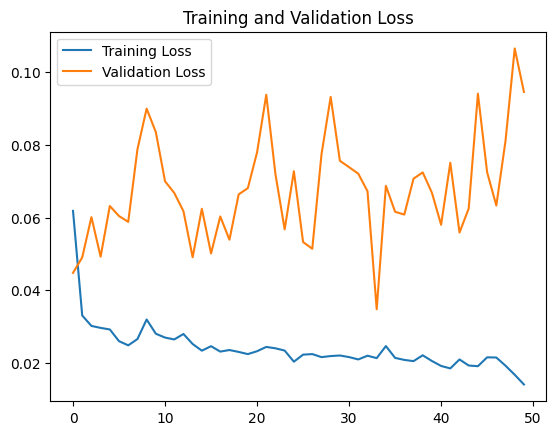

In [10]:
# create a plot of the loss and validation loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

Input data shape: (122, 120, 8)
Expected sequence length: 120, Features count: 8


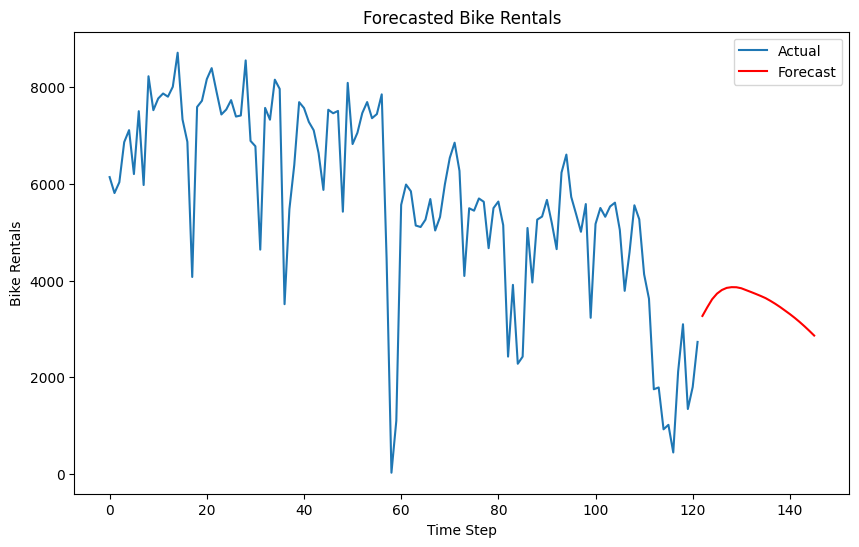

In [11]:
def forecast_future(data, model, seq_length, steps, features_count):
    # Debugging information
    print(f"Input data shape: {data.shape}")
    print(f"Expected sequence length: {seq_length}, Features count: {features_count}")
    
    # Ensure data has the correct shape
    if len(data.shape) == 3:
        data = data[-1]  # Take the last sequence if data is already 3D
    elif len(data.shape) == 2:
        data = data[-seq_length:]  # Take the last 'seq_length' rows if 2D
    else:
        raise ValueError(f"Unexpected data shape: {data.shape}")

    # Validate reshaping
    if data.shape[0] != seq_length or data.shape[1] != features_count:
        raise ValueError(f"Cannot reshape data of shape {data.shape} into (1, {seq_length}, {features_count})")
    
    forecast = data.reshape(1, seq_length, features_count)
    predictions = []

    # Generate future predictions
    for i in range(steps):
        prediction = model.predict(forecast, verbose=0)
        predictions.append(prediction[0, 0])  # Extract single value
        # Slide the window and append the prediction
        forecast = np.append(forecast[:, 1:, :], np.full((1, 1, features_count), prediction[0, 0]), axis=1)

    return predictions

steps = 24  # Forecast 24 future steps (hours)
features_count = X_test.shape[2]  # Number of features in the input

# Use the last sequence from X_test
future_forecast = forecast_future(X_test, model, seq_length, steps, features_count)

# Inverse transform the forecasted values to original scale
future_forecast = scaler_target.inverse_transform(np.array(future_forecast).reshape(-1, 1))

# Create the figure with actual and forecasted values
fig = go.Figure()

# Add actual values trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test_actual))),
    y=y_test_actual.flatten(),
    mode='lines',
    name='Actual'
))

# Add forecasted values trace
fig.add_trace(go.Scatter(
    x=list(range(len(y_test_actual), len(y_test_actual) + steps)),
    y=future_forecast.flatten(),
    mode='lines',
    name='Forecast',
    line=dict(color='red')
))

# Update layout
fig.update_layout(
    title='Hourly Bike Rentals Forecast using LSTM',
    xaxis_title='Time Step',
    yaxis_title='Bike Rentals',
    legend=dict(x=0, y=1)
)

# Show the figure
fig.show()

# Plot forecasted values alongside actual values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test_actual)), y_test_actual, label='Actual')
plt.plot(range(len(y_test_actual), len(y_test_actual) + steps), future_forecast, label='Forecast', color='red')
plt.legend()
plt.title('Forecasted Bike Rentals')
plt.xlabel('Time Step')
plt.ylabel('Bike Rentals')
plt.show()

# Save the trained LSTM model for future use
model.save('bike_rentals_lstm_model.h5')

In [12]:
# SHOW THE MATRIX OF THE MODEL 
print(model.summary())


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 120, 128)       │        70,144 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 120, 128)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 364,997 (1.39 MB)

 Trainable params: 121,665 (475.25 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 243,332 (950.52 KB)

None


In [13]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Make predictions
predictions = model.predict(X_test)
predictions = scaler_target.inverse_transform(predictions)

# Inverse transform the actual values
y_test_actual = scaler_target.inverse_transform(y_test.reshape(-1, 1))

# Calculate performance metrics
mae = mean_absolute_error(y_test_actual, predictions)
mse = mean_squared_error(y_test_actual, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test_actual, predictions)

print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"R-squared (R²): {r2}")



4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Mean Absolute Error (MAE): 2433.9152711962092
Mean Squared Error (MSE): 7144593.482225033
Root Mean Squared Error (RMSE): 2672.937238736636
R-squared (R²): -0.8605205337114479
